# profile likelihood scans on the Asimov dataset

In this notebook we will:

   * generate the Asimov dataset
   * carry out likelihood scans for a number of nuisance parameters while minimizing the NLL w.r.t. all other nuisance parameters
   
This first part is based of `w_br_asimov.ipynb`.

In [96]:
## imports and configuration
%cd '/home/naodell/work/wbr/analysis'

from functools import partial
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from scipy.optimize import minimize
from tqdm import tqdm_notebook

import scripts.plot_tools as pt
import scripts.fit_helpers as fh
from nllfit.nllfitter import ScanParameters

np.set_printoptions(precision=5)
matplotlib.style.use('default')
params = {'legend.fontsize': 20,
          'axes.labelsize': 20,
          'figure.figsize': (8, 8),
          'axes.facecolor': 'white',
          'axes.titlesize':'x-large',
          'xtick.labelsize':18,
          'ytick.labelsize':18,
         }
matplotlib.rcParams.update(params)
%matplotlib inline
%connect_info

/home/naodell/work/wbr/analysis
{
  "shell_port": 47775,
  "iopub_port": 34627,
  "stdin_port": 37207,
  "control_port": 51197,
  "hb_port": 52649,
  "ip": "127.0.0.1",
  "key": "3d83209e-c4bbc3cda1dd9ffc718b4530",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-83b2660f-a13a-4a00-a4e4-d8368a97addf.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.


In [97]:
# configure, get the input data, and do any additional processing that is needed
input_dir  = f'local_data/templates/btag_fix/'
selections = [
              'emu', 
              'mumu',  'mutau',  'mu4j',
              'ee',  'etau', 'e4j'
             ]
n_selection = len(selections)
targets    = dict(
                  mumu  = 'lepton2_pt', 
                  ee    = 'lepton2_pt', 
                  emu   = 'trailing_lepton_pt', 
                  mutau = 'lepton2_pt', 
                  etau  = 'lepton2_pt', 
                  mu4j  = 'lepton1_pt',
                  e4j   = 'lepton1_pt'
                 )
plot_labels = dict(
                   mumu  = [r'$\sf p_{T, \mu}$', r'$\mu\mu$'],
                   ee    = [r'$\sf p_{T, e}$', r'$ee$'],
                   emu   = [r'$\sf p_{T, \ell}$', r'$e\mu$'],
                   mutau = [r'$\sf p_{T, \tau}$', r'$\mu\tau$'],
                   etau  = [r'$\sf p_{T, \tau}$', r'$e\tau$'],
                   mu4j  = [r'$\sf p_{T, \mu}$', r'$\mu$ + jets'],
                   e4j   = [r'$\sf p_{T, e}$', r'$e$ + jets']
                  )

# initial values for W branching fraction (beta_e, beta_mu, beta_tau, beta_h) and tau branching fraction (b_e, b_mu, b_h)
br_tau    = [0.1783, 0.1741, 0.6476]
beta_init = [0.108, 0.108, 0.108, 1 - 3*0.108] 
var_beta  = [0.0009**2, 0.0009**2, 0.0009**2, 0.0031**2]

# initialize fit data
fit_data = fh.FitData(input_dir, selections, targets)

# pull data
pull_data  = pd.read_csv('local_data/pulls.csv', index_col=0)
param_data = pd.read_csv('data/model_parameters_partial.csv').set_index('name')
jes_mask = np.array([True if 'jes' in pname else False for pname in pull_data.index])

In [98]:
# generate Asimov dataset
toy_data = dict()
for selection in selections:
    toy_data[selection] = dict()
    sdata = fit_data.get_selection_data(selection)
    for category, bdata in sdata.items():
        
        templates = bdata['templates']
        # signal component
        toy_data[selection][category] = np.zeros(bdata['bins'].size - 1)
        for dataset, template in templates.items():
            if dataset in['ttbar', 't', 'wjets']: 
                signal_template = pd.DataFrame.from_items((dm, t['val']) for dm, t in template.items())
                signal = fh.signal_mixture_model(beta_init, br_tau, signal_template, sample=False, single_w=(dataset == 'wjets'))
                toy_data[selection][category] += signal
            elif dataset != 'data':
                toy_data[selection][category] += template['val']

/home/naodell/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  del sys.path[0]


In [99]:
# Handy functions
def reduced_objective(params, data, obj, mask, p_init):
    '''
    Fixes parameters specified by (p, mask) and minimizes objective w.r.t. remaining parameters.
    '''
    masked_params = p_init.copy()
    masked_params[~mask] = params
    return obj(masked_params, data)

def obj_callback(params, objective, data, cache, verbose=False):
    cache['params'].append(params)
    cache['cost'].append(objective(params, data))
    
    if verbose:
        print(objective(params, data))

In [100]:
# configure likelihood scan parameters
param_name = 'beta_h'
nscan_points = 25

# get parameter data
params_init = fit_data.get_params_init(as_array=True)
err_init = fit_data.get_errs_init(as_array=True)
param = fit_data._parameters.loc[param_name]
ix = list(fit_data._parameters.index).index(param_name)

# remove constant offset from likelihood
fit_data._cost_init = 0
fit_data._cost_init = fit_data.objective(params_init, toy_data)

# generate scan points between +/- 2 sigma
if param_name in ['beta_e', 'beta_mu', 'beta_tau']:
    pmin, pmax = 0.1, 0.12
elif param_name == 'beta_h':
    pmin, pmax = 0.65, 0.7
else:
    pmin, pmax = param.val_init - 2*param.err_init, param.val_init + 2*param.err_init
scan_points = np.linspace(pmin, pmax, nscan_points)

mask = np.zeros(len(params_init)).astype(bool)
mask[ix] = True

In [101]:
# evaluate at one point

p = params_init.copy()
p[ix] = scan_points[0]

#step_size = 1e-8*np.delete(err_init, ix)
#step_size[:4] = 1e-8
step_size = 1e-8

fobj = partial(reduced_objective, obj=fit_data.objective, mask=mask, p_init=p)
nll_cache = dict(params = [], cost = [])
res_reduced = minimize(fobj, np.delete(params_init, ix), 
                       method = 'BFGS', 
                       #jac = True, 
                       #hess = True, 
                       args = (toy_data),
                       #iprint = 5,
                       options = {'disp':True},#, 'eps':step_size, 'ftol':1e-8, 'gtol':1e-6},
                       callback = partial(obj_callback, objective=fobj, data=toy_data, cache=nll_cache),
                      )

nll_nominal = fit_data.objective(p, toy_data)
nll_min = fit_data.objective(params_init, toy_data)
nll_prior = 0.5*(params_init[ix] - p[ix])**2/param.err_init**2

print(nll_nominal - res_reduced.fun)
print(nll_prior - (res_reduced.fun - nll_min))

         Current function value: 43.347715
         Iterations: 419
         Function evaluations: 30536
         Gradient evaluations: 587
338722.98751492053
-43.34697509953785


In [102]:
# carry out one-dimensional profile likelihood scans
from multiprocessing import Pool
pool = Pool(processes=12)
results = []
nll_scan = []
for sp in scan_points:
    p = params_init.copy()
    p[ix] = sp
    fobj = partial(reduced_objective, obj=fit_data.objective, mask=mask, p_init=p)
    nll_scan.append(fobj(np.delete(p, ix), toy_data))
    res = pool.apply_async(minimize, args=(fobj, np.delete(p, ix)), 
                           kwds={'args':(toy_data), 
                                 'method':'BFGS', 
                                 #'options': {'eps':step_size, 'ftol':1e-11}
                                }
                          )
    #res = pool.apply_async(minimize, args=(fit_data.objective, p), 
    #                       kwds={'args':(toy_data), 
    #                             'method':'BFGS', 
    #                             #'options': {'eps':step_size, 'gtol':1e-6}
    #                            }
    #                      )
    results.append(res)
    
pool.close()
pool.join()

print('All done!!!')

results = [r.get() for r in results]
nll_profile_scan = [r.fun for r in results]

All done!!!


/home/naodell/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


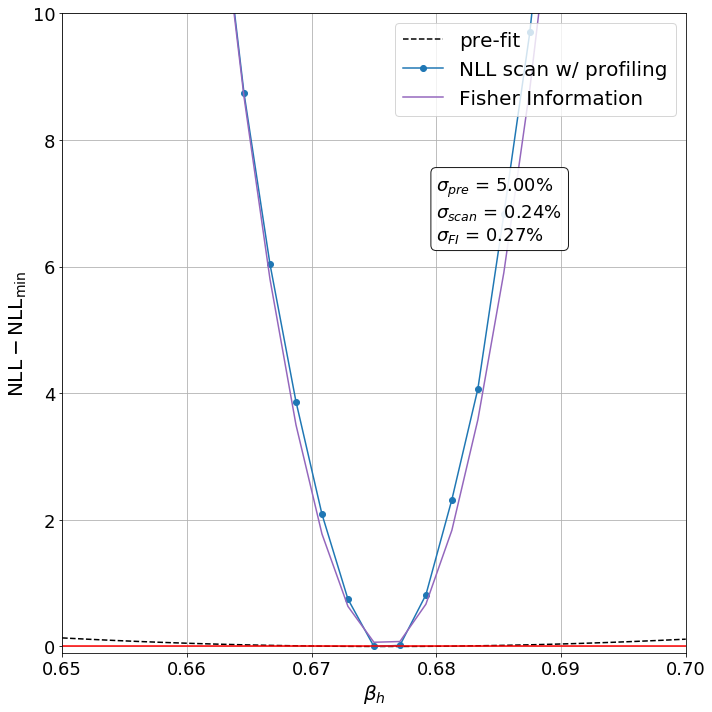

In [105]:
# money plot
fig, ax = plt.subplots(1, 1, figsize=(10, 10), facecolor='white', sharey=False)

if param_name in ['beta_e', 'beta_mu']:
    sigma_fisher = 0.0009
    param.err_init = 0.01
elif param_name == 'beta_tau':
    sigma_fisher = 0.0015
    param.err_init = 0.01
elif param_name == 'beta_h':
    sigma_fisher = 0.00274
    param.err_init = 0.05
else:
    sigma_fisher = pull_data.loc[param_name]['stderr_post (%)']/100
    

nll_min = np.min(nll_profile_scan)
nll_coeff = np.polyfit(scan_points, (nll_profile_scan - nll_min), deg=2, w=np.exp(-0.5*(params_init[ix] - scan_points)**2/sigma_fisher**2))
nll_poly = np.poly1d(nll_coeff)
d_nll_poly = np.polyder(nll_poly, m=2)
sigma_post = 1/np.sqrt(d_nll_poly(0))

ax.plot(scan_points, 0.5*(params_init[ix] - scan_points)**2/param.err_init**2, 'k--', linewidth=1.5)
#ax.plot(scan_points, (nll_scan - np.min(nll_scan))/2, 'C1o:', linewidth=1.5)
ax.plot(scan_points, (nll_profile_scan - nll_min), 'C0o-', linewidth=1.5)
#ax.plot(scan_points, nll_poly(scan_points), 'r:', linewidth=1.5)
ax.plot(scan_points, 0.5*(params_init[ix] - scan_points)**2/sigma_fisher**2, 'C4-', linewidth=1.5)
ax.plot([scan_points[0], scan_points[-1]], [0, 0], 'r-', linewidth=1.5, label='_nolegend_')

ax.set_xlim(0.04, 0.2)
ax.set_xlim(scan_points[0], scan_points[-1])
#ax.set_ylim(-0.1, np.max(nll_profile_scan - nll_min))
ax.set_ylim(-0.1, 10)
ax.set_xlabel(param.label)
ax.set_ylabel('$\sf NLL - NLL_{min}$')
ax.grid()

ax.legend(['pre-fit', 'NLL scan w/ profiling', 'Fisher Information'], loc=1)
ax.text(0.6, 0.65, 
        r'$\sigma_{pre}$' + f' = {param.err_init:.2%} \n' 
        + r'$\sigma_{scan}$' + f' = {sigma_post:.2%} \n' 
        + r'$\sigma_{FI}$' + f' = {sigma_fisher:.2%}', 
        transform=ax.transAxes,
        fontsize=18,
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.9)
       )

plt.tight_layout()
plt.savefig(f'plots/systematics/nll_scan_{param_name}.pdf')
plt.show()